In [3]:
from utils.task import add_task_identity, get_input
from utils.analysis import get_all_hiddens, get_attractors, plot_pca, get_speed, get_unique_fixed_points, visualize_fixed_points, is_stable
from utils.model import MultitaskRNN, plot_behavior
from utils.utils import get_model, get_fixed_points

import torch
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import os
os.environ['KMP_WARNINGS'] = '0'

# Network behavior

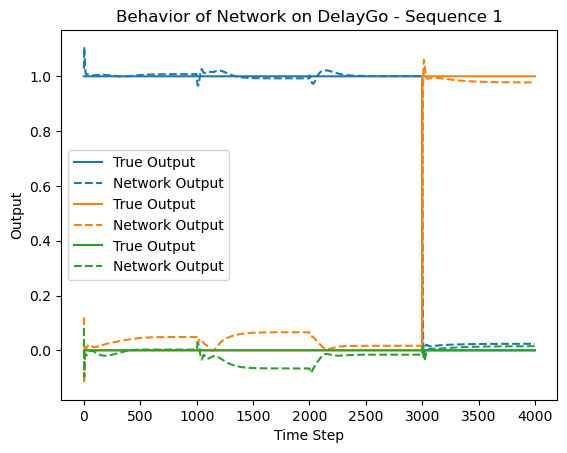

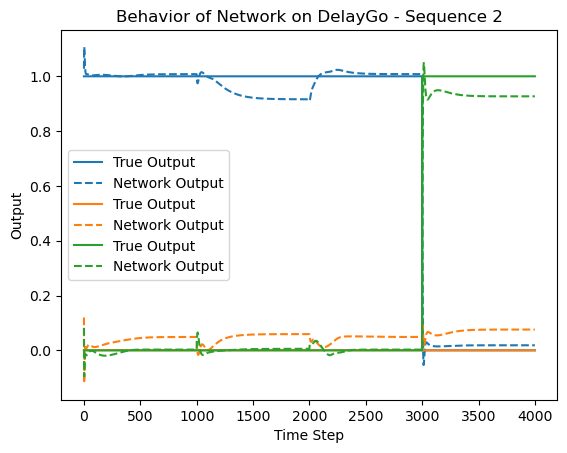

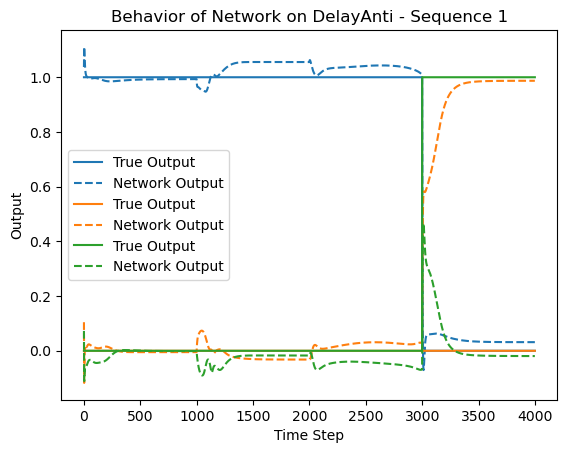

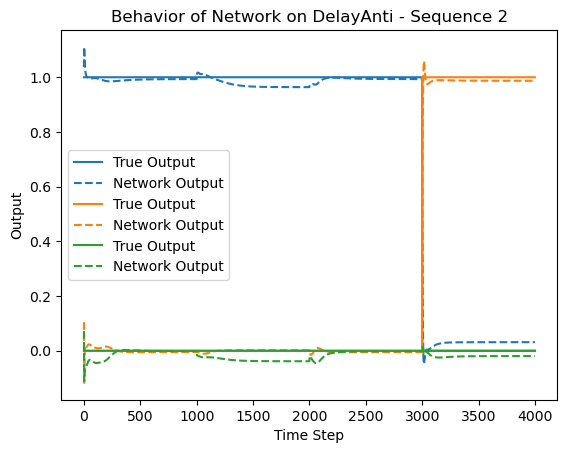

In [25]:
model_name = "delaygo_delayanti_255"
rnn, tasks = get_model(model_name)

period_duration=1000
plot_behavior(rnn, tasks, period_duration=period_duration)

## Find Fixed Points

In [17]:
all_hiddens = get_all_hiddens(rnn, tasks)

In [20]:
task_idx = [0,1]
period = ["delay", "delay"]
stimulus = [1, 1]

input1 = get_input(task_idx[0], period[0], stimulus[0], tasks)
input2 = get_input(task_idx[1], period[1], stimulus[1], tasks)

n_interp = 20
i = 20
interpolated_input = (n_interp - i)/n_interp * input1 + (i/n_interp) * input2
print(interpolated_input)

fps = get_fixed_points(model_name, interpolated_input)

tensor([1., 0., 0., 0., 1.])


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


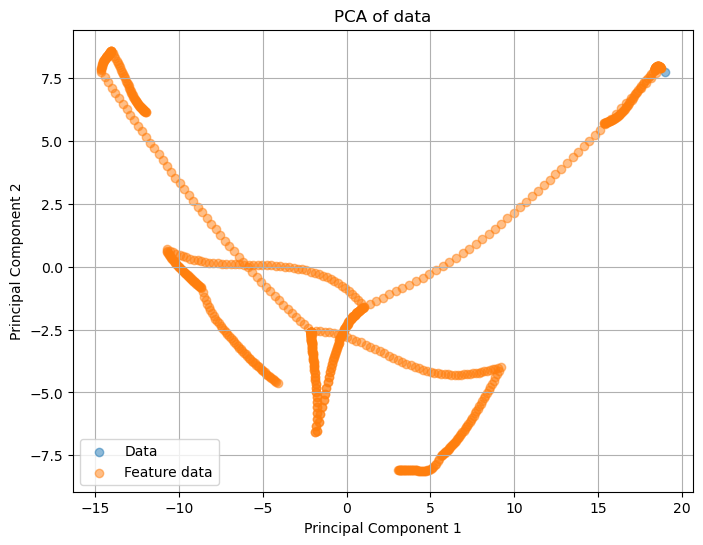

In [21]:
unique_fps = get_unique_fixed_points(fps.detach())

plot_pca(unique_fps.detach().numpy(), all_hiddens.detach().numpy(), True)

In [22]:
get_speed(rnn, interpolated_input, unique_fps.float())

tensor([6.6077e-11], grad_fn=<MulBackward0>)

In [23]:
for fp in unique_fps:
    if is_stable(rnn, fp, interpolated_input):
        print("The fixed point is stable.")
    else:
        print("The fixed point is unstable.")

The fixed point is stable.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


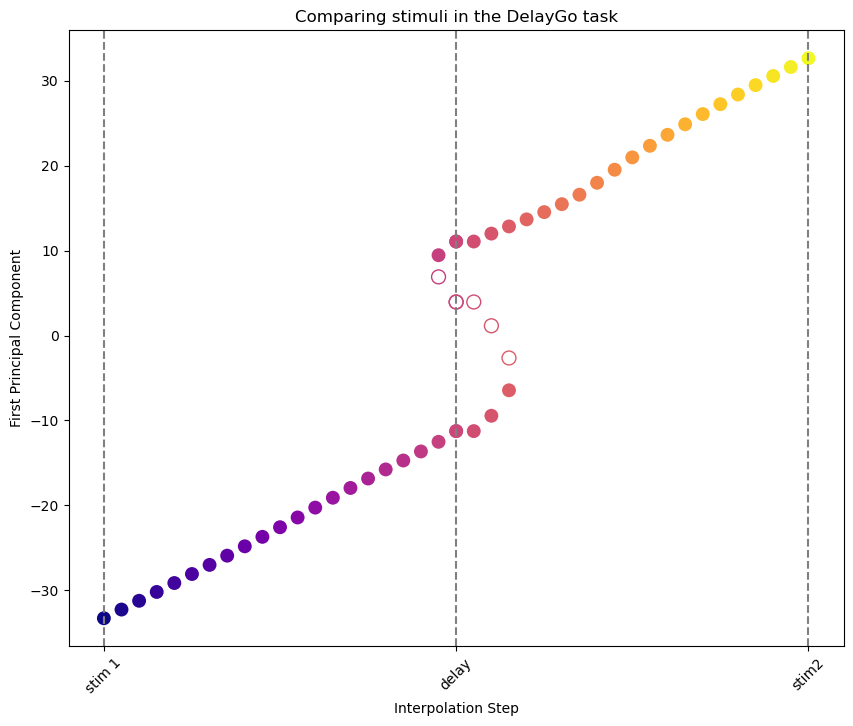

In [26]:
task_idx = [0,0,0]
period = ["stim", "delay", "stim"]
stimulus = [1,1,2]
n_interp = 20
labels = ["stim 1" , "delay", "stim2"]
title = "Comparing stimuli in the DelayGo task"
save_fig = None

visualize_fixed_points(model_name, task_idx, period, stimulus, n_interp, input_labels = labels, title = title, save_fig=save_fig)

## Attractors

In [6]:
all_hiddens = get_all_hiddens(rnn, tasks)

In [5]:
task_idx = [0,0]
period = ["fix", "stim"]
stimulus = [1, 1]

input1 = get_input(task_idx[0], period[0], stimulus[0], tasks)
input2 = get_input(task_idx[1], period[1], stimulus[1], tasks)

n_interp = 20
i = 2
interpolated_input = (n_interp - i)/n_interp * input1 + (i/n_interp) * input2
print(interpolated_input)

tensor([1.0000, 0.1000, 0.0000, 1.0000, 0.0000])


In [6]:
num_timesteps = 1000
num_last = 100

attractors = get_attractors(rnn, interpolated_input, all_hiddens, num_timesteps, num_last)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


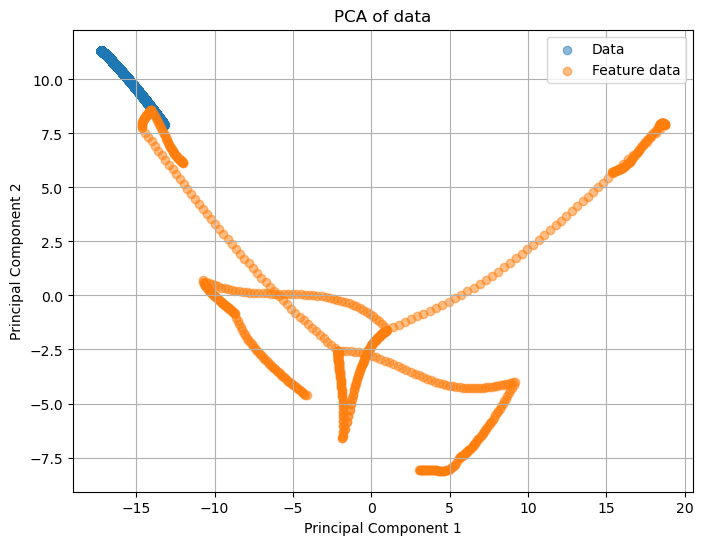

In [7]:
attractors_2d = attractors.reshape(-1, attractors.shape[-1])
plot_pca(attractors_2d.detach().numpy(), all_hiddens.detach().numpy(), plot_feature_data=True)  # convert tensors to numpy arrays for use with sklearn

In [8]:
get_speed(rnn, interpolated_input, attractors[0,:,:])

tensor([7.4635e-08, 7.1473e-08, 6.9079e-08, 6.7068e-08, 6.4691e-08, 6.2948e-08,
        6.0974e-08, 5.8854e-08, 5.6849e-08, 5.4906e-08, 5.3241e-08, 5.1477e-08,
        5.0007e-08, 4.8410e-08, 4.7026e-08, 4.5543e-08, 4.4393e-08, 4.3034e-08,
        4.1549e-08, 4.0235e-08, 3.9060e-08, 3.7694e-08, 3.6574e-08, 3.5626e-08,
        3.4252e-08, 3.3089e-08, 3.2206e-08, 3.1321e-08, 3.0294e-08, 2.9367e-08,
        2.8305e-08, 2.7433e-08, 2.6493e-08, 2.5525e-08, 2.4964e-08, 2.4033e-08,
        2.3311e-08, 2.2523e-08, 2.1818e-08, 2.0965e-08, 2.0268e-08, 1.9548e-08,
        1.8861e-08, 1.8263e-08, 1.7634e-08, 1.7046e-08, 1.6332e-08, 1.5797e-08,
        1.5549e-08, 1.5062e-08, 1.4493e-08, 1.4028e-08, 1.3625e-08, 1.3284e-08,
        1.2868e-08, 1.2357e-08, 1.1970e-08, 1.1587e-08, 1.1179e-08, 1.0900e-08,
        1.0442e-08, 1.0211e-08, 9.7635e-09, 9.4452e-09, 9.1713e-09, 8.8723e-09,
        8.7434e-09, 8.3881e-09, 8.2014e-09, 7.9548e-09, 7.7419e-09, 7.4008e-09,
        7.2406e-09, 6.9592e-09, 6.6708e-

## Minimize speed for interpolated input

In [3]:
from utils.analysis import minimize_speed

In [4]:
task_idx = [0,0]
period = ["fix", "stim"]
stimulus = [1, 1]

input1 = get_input(task_idx[0], period[0], stimulus[0], tasks)
input2 = get_input(task_idx[1], period[1], stimulus[1], tasks)

n_interp = 20
i = 2
interpolated_input = (n_interp - i)/n_interp * input1 + (i/n_interp) * input2
print(interpolated_input)

tensor([1.0000, 0.1000, 0.0000, 1.0000, 0.0000])


In [7]:
sample_proportion = 0.1 

# Determine the number of samples from the proportion of hidden states
hidden_state_count = all_hiddens.size(0)
num_samples = int(hidden_state_count * sample_proportion)  # Calculate the number of samples

# Randomly permute the indices and select the first num_samples
indices = torch.randperm(hidden_state_count)[:num_samples]  
sampled_hiddens = all_hiddens[indices]  # Select the sampled hidden points using the sampled indices

In [9]:
lr = 0.1
q_thresh = 1e-6
max_iterations = None
method='second'

fps = minimize_speed(rnn, interpolated_input, sampled_hiddens, lr, q_thresh, max_iterations=max_iterations, method=method)

Iteration 0: maximum speed across all initial conditions is 1.7415039539337158
Time taken for the last 10000 iterations: 0.13432073593139648 seconds.
Removing 64 bad local minima at iteration 10000.
Iteration 10000: maximum speed across all initial conditions is 0.0016223415732383728
Time taken for the last 10000 iterations: 57.15449404716492 seconds.
Stopping optimization: maximum speed across all initial conditions is below the threshold.


In [10]:
get_speed(rnn, interpolated_input, fps)

tensor([5.6711e-11, 4.2568e-10, 3.3096e-11, 4.1429e-11, 2.8599e-10, 5.1583e-11,
        3.0176e-09, 2.2224e-09, 1.6560e-10, 4.3229e-10, 1.1150e-10, 3.1263e-11,
        1.1309e-10, 4.8148e-11, 1.8358e-11, 2.8231e-11],
       grad_fn=<MulBackward0>)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


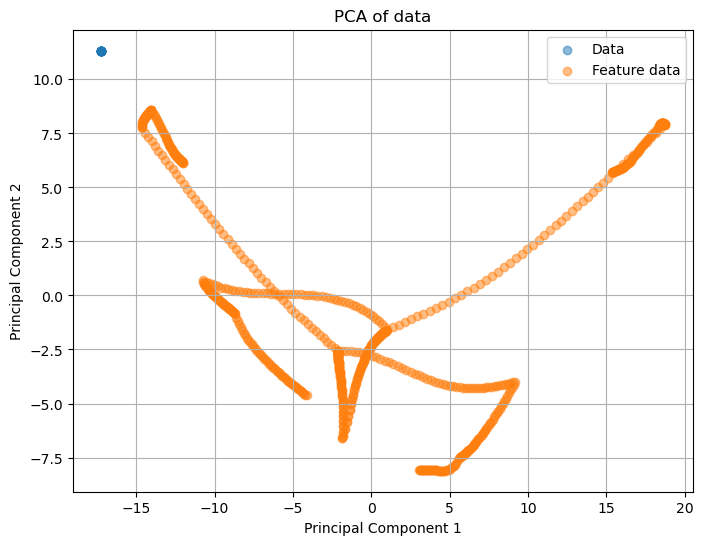

In [11]:
plot_pca(fps.detach().numpy(), all_hiddens.detach().numpy(), plot_feature_data=True)  # convert tensors to numpy arrays for use with sklearn

## Cluster to find unique fixed points

In [ ]:
from sklearn.cluster import DBSCAN
from utils.utils import get_model, get_model_path

# Set up model and paths
model_name = "delaygo_delayanti_255"
model_path = get_model_path(model_name)
analysis_path = os.path.join(model_path, "analysis")

# Load model and recurrent weights
rnn, _ = get_model(model_name)
W_rec = rnn.state_dict()['weight_hh_l0']

# Function to load fixed points and perform DBSCAN
def perform_dbscan(input_str):
    # Load the fixed points
    fixed_points = torch.load(os.path.join(analysis_path, f'fixed_points_{input_str}.pt'))

    # Convert to numpy for compatibility with DBSCAN
    fixed_points_np = fixed_points.numpy()

    # Apply DBSCAN
    dbscan = DBSCAN(eps=0.3, min_samples=2)  # You may want to adjust these parameters
    dbscan.fit(fixed_points_np)

    # Group fixed points into clusters and calculate eigenvalues for each unique point
    unique_labels = set(dbscan.labels_)
    for label in unique_labels:
        if label == -1:
            continue  # Skip noise
        idx = dbscan.labels_ == label
        cluster_points = fixed_points_np[idx]
        # Find a representative point for this cluster
        representative_point = cluster_points.mean(axis=0)
